# 1. Import Libraries

In [17]:
import os
import requests
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# 2. Download Images from Github

### 2.1 Define Github Parameters

In [2]:
GITHUB_REPO = "prattapong/Data-Science-Portfolio"
GITHUB_FOLDER = "Projects/Commercial%20Airplane%20Model%20Image%20Classification/images"
GITHUB_API_URL = f"https://api.github.com/repos/{GITHUB_REPO}/contents/{GITHUB_FOLDER}"

### 2.2 Get each images url from Github

In [3]:
def get_image_urls():
    response = requests.get(GITHUB_API_URL)
    if response.status_code != 200:
        raise Exception(f"Error fetching images: {response.json()}")

    image_urls = {}
    for folder in response.json():
        if folder["type"] == "dir":
            class_name = folder["name"]
            image_urls[class_name] = []
            folder_url = folder["url"]

            # Fetch image files in each class folder
            folder_response = requests.get(folder_url)
            if folder_response.status_code == 200:
                for file in folder_response.json():
                    if file["name"].lower().endswith((".jpg", ".jpeg", ".png")):
                        image_urls[class_name].append(file["download_url"])

    return image_urls

### 2.3 Load images and assign to variable X and y

In [30]:
def load_images(image_urls):
    IMG_SIZE = (448, 448)
    X, y = [], []

    for label, urls in image_urls.items():
        for url in urls:
            try:
                response = requests.get(url)
                img = Image.open(BytesIO(response.content)).convert("RGB")
                img = img.resize(IMG_SIZE)
                X.append(np.array(img) / 255.0)  # Normalize
                y.append(label)
            except Exception as e:
                print(f"Error loading {url}: {e}")

    return np.array(X), pd.Categorical(y).codes

### 2.4 Display a sample

In [31]:
image_urls = get_image_urls()
X, y = load_images(image_urls)

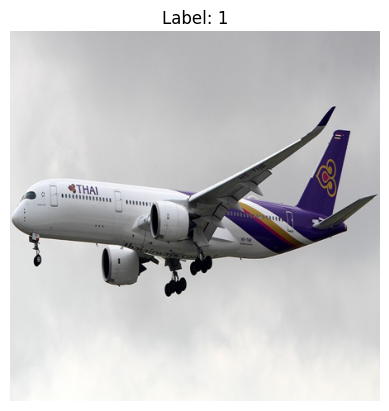

In [32]:
# Display the image
plt.imshow(X[10])
plt.axis("off")
plt.title(f"Label: {y[10]}")
plt.show()

# 3. Data Augmentation

In [33]:
def augment_data(X_train):
    # Create an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    # Fit the generator to the training data
    datagen.fit(X_train)

    return datagen

# 4. Train Model Using ResNet 50 with Augmentation

In [36]:
def train_model(X, y, batch_size:int, epochs:int):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(448, 448, 3))

    # Freeze pretrained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(len(set(y)), activation="softmax")(x)  # Output layer for classification

    model = Model(inputs=base_model.input, outputs=x)

    # Build the model
    model.build((None, 448, 448, 3))  # Build the model with the input shape

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # Perform data augmentation
    datagen = augment_data(X_train)

    # Set up ModelCheckpoint to save the best model
    checkpoint = ModelCheckpoint('best_airplane_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train model using augmented data
    model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])

    # Load and print the best model
    best_model = tf.keras.models.load_model('best_airplane_model.h5')
    print("Best model saved as 'best_airplane_model.h5'")

    return best_model

In [37]:
train_model(X, y, batch_size = 8, epochs = 100)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1779 - loss: 1.4808  
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_airplane_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 12s/step - accuracy: 0.1955 - loss: 1.4477 - val_accuracy: 0.2500 - val_loss: 1.0583
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3798 - loss: 1.1359
Epoch 2: val_accuracy did not improve from 0.25000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.3814 - loss: 1.1355 - val_accuracy: 0.2500 - val_loss: 1.3861
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.4923 - loss: 1.0464
Epoch 3: val_accuracy did not improve from 0.25000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - accuracy: 0.4564 - loss: 1.0677 - val_accuracy: 0.2500 - val_loss: 1.6559
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2788 - loss: 1.1308
Epoch 4: val_accuracy did not improve from 0.25000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.2885 - loss: 1.1228 - val_accuracy: 0.2500 - val_loss: 1.7597
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.2548 - loss: 1.1364
Epoch 5: val_accuracy did not improve from 0.250

Best model saved as 'best_airplane_model.h5'


<Functional name=functional_5, built=True>

In [26]:
augment_data(X)

TypeError: object of type 'ImageDataGenerator' has no len()